# Initiate Settings

In [281]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- n(z) and binning utility ---
def parent_nz(z): return z**2 * np.exp(-(z / 0.176)**0.783)
    

def make_bins(nz_func, z, nbins):
    nz = nz_func(z); nz /= np.trapz(nz, z)
    cdf = np.cumsum(nz); cdf /= cdf[-1]
    inv_cdf = interp1d(np.concatenate(([0], cdf, [1])),
                       np.concatenate(([z[0]], z, [z[-1]])))
    edges = inv_cdf(np.linspace(0, 1, nbins + 1))
    bins = []
    for i in range(nbins):
        mask = (z >= edges[i]) & (z <= edges[i + 1])
        nz_bin = np.zeros_like(z); nz_bin[mask] = nz[mask]
        nz_bin /= np.trapz(nz_bin, z)
        smoothed = np.zeros_like(z)
        for j, zj in enumerate(z):
            kernel = norm.pdf(z - zj, scale=0.05 * (1 + zj))
            #kernel = norm.pdf(z - zj, scale=0.0005 * (1 + zj))
            
            kernel /= np.trapz(kernel, z)
            smoothed[j] = np.trapz(nz_bin * kernel, z)
        smoothed /= np.trapz(smoothed, z)
        bins.append((z.copy(), smoothed.copy()))
    return bins

# --- Survey and cosmology settings ---
z = np.linspace(0.01, 4.0, 1000)
nz_lens = make_bins(parent_nz, z, 10)
nz_src = make_bins(parent_nz, z, 10)


def ell_eff_uniform_weighting(ell_min, ell_max):
    ells = np.arange(ell_min, ell_max + 1)  # Include ell_max
    log_ell_mean = np.mean(np.log(ells))    # Uniform weights
    ell_eff = np.exp(log_ell_mean)
    return ell_eff

ell_min = 100
ell_max = 2000

ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
print(f"Effective multipole (uniform weighting) for band [{ell_min}, {ell_max}]: {ell_eff:.2f}")

area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}


Effective multipole (uniform weighting) for band [100, 2000]: 861.11


# Build the class

In [326]:
import numpy as np
import pyccl as ccl
import PySSC
from getdist import MCSamples
import getdist.plots as gdplt

class Forecast3x2pt:
    def __init__(self,
                 nz_lens,
                 nz_src,
                 ell,
                 area_deg2,
                 n_eff,
                 sigma_eps,
                 bias_lens,
                 fid_cosmo,
                 use_ssc=True,
                 marginalize_delta_z_lens=False,
                 marginalize_delta_z_src=False,
                 delta_z_lens_prior_std=0.002,
                 delta_z_src_prior_std=0.002,
                 marginalize_multiplicative_bias=False,
                 multiplicative_bias_prior_std=0.005):   

        """
        Initialize the forecast object for a 3x2pt analysis.
        """
        self.nz_lens = nz_lens
        self.nz_src = nz_src
        self.ell = np.array(ell)
        self.area_deg2 = area_deg2
        self.n_eff = n_eff
        self.sigma_eps = sigma_eps
        self.bias_lens = np.array(bias_lens)
        self.fid_cosmo = fid_cosmo
        self.use_ssc = use_ssc

        self.marginalize_delta_z_lens = marginalize_delta_z_lens
        self.marginalize_delta_z_src = marginalize_delta_z_src
        self.delta_z_lens_prior_std = delta_z_lens_prior_std
        self.delta_z_src_prior_std = delta_z_src_prior_std
        self.marginalize_multiplicative_bias = marginalize_multiplicative_bias  
        self.multiplicative_bias_prior_std = multiplicative_bias_prior_std      

        self._init_cosmology()

    def _init_cosmology(self):
        """
        Set up pyccl cosmology object.
        """
        self.cosmo = ccl.Cosmology(
            Omega_c=self.fid_cosmo["Omega_m"] - self.fid_cosmo["Omega_b"],
            Omega_b=self.fid_cosmo["Omega_b"],
            h=self.fid_cosmo["h"],
            sigma8=self.fid_cosmo["sigma_8"],
            n_s=self.fid_cosmo["n_s"],
            w0=self.fid_cosmo["w0"],
            wa=self.fid_cosmo["wa"],
            extra_parameters={'camb': {'dark_energy_model': 'ppf'}}
        )

    def plot_nz_bins(self):
        """
        Plot the normalized redshift distributions for lens and source bins.
        """
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
        colors = plt.cm.viridis(np.linspace(0, 1, max(len(self.nz_lens), len(self.nz_src))))

        for i, (z, nz) in enumerate(self.nz_lens):
            axes[0].plot(z, nz, label=f'Lens bin {i+1}', color=colors[i])
        axes[0].set_title("Lens Bins")
        axes[0].set_xlabel("z")
        axes[0].set_ylabel("n(z)")
        axes[0].legend()

        for i, (z, nz) in enumerate(self.nz_src):
            axes[1].plot(z, nz, label=f'Source bin {i+1}', color=colors[i])
        axes[1].set_title("Source Bins")
        axes[1].set_xlabel("z")
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    def compute_cls(self):
        """
        Compute angular power spectra for gg, gk, and kk.
        """
        n_lens = len(self.nz_lens)
        n_src = len(self.nz_src)
        ell = self.ell

        lens_tracers = []
        for i, (z, nz) in enumerate(self.nz_lens):
            bias = self.bias_lens[i]
            lens_tracers.append(
                ccl.NumberCountsTracer(
                    self.cosmo,
                    has_rsd=False,
                    dndz=(z, nz),
                    bias=(z, bias * np.ones_like(z))
                )
            )

        src_tracers = [
            ccl.WeakLensingTracer(self.cosmo, dndz=(z, nz))
            for (z, nz) in self.nz_src
        ]

        cl_gg = np.zeros((n_lens, n_lens, len(ell)))
        cl_gk = np.zeros((n_lens, n_src, len(ell)))
        cl_kk = np.zeros((n_src, n_src, len(ell)))

        for i in range(n_lens):
            for j in range(i, n_lens):
                cl = ccl.angular_cl(self.cosmo, lens_tracers[i], lens_tracers[j], ell)
                cl_gg[i, j] = cl
                cl_gg[j, i] = cl

        for i in range(n_lens):
            for j in range(n_src):
                cl = ccl.angular_cl(self.cosmo, lens_tracers[i], src_tracers[j], ell)
                cl_gk[i, j] = cl

        for i in range(n_src):
            for j in range(i, n_src):
                cl = ccl.angular_cl(self.cosmo, src_tracers[i], src_tracers[j], ell)
                cl_kk[i, j] = cl
                cl_kk[j, i] = cl

        return {"gg": cl_gg, "gk": cl_gk, "kk": cl_kk}

    def extract_gk_vector(self, cl_dict):
        """
        Extract vector of C_ell^{g_i kappa_j} where j > i.
        """
        cl_gk = cl_dict["gk"]
        n_lens, n_src, n_ell = cl_gk.shape

        gk_vector = []
        labels = []

        for i in range(n_lens):
            for j in range(n_src):
                if j > i:
                    gk_vector.append(cl_gk[i, j])
                    labels.append(f"g{i+1}k{j+1}")

        gk_vector = np.array(gk_vector)
        return gk_vector, labels

    def compute_gk_covariance_matrix_gauss(self, cl_dict, ell, delta_ell):
        """
        Compute the Gaussian covariance matrix for gk_vector.
        """
        cl_gg = cl_dict["gg"]
        cl_gk = cl_dict["gk"]
        cl_kk = cl_dict["kk"]
        n_lens = len(self.nz_lens)
        n_src = len(self.nz_src)

        indices = []
        labels = []
        for i in range(n_lens):
            for j in range(n_src):
                if j > i:
                    indices.append((i, j))
                    labels.append(f"g{i+1}k{j+1}")

        N = len(indices)

        steradian_conversion = 3600 * (180 / np.pi)**2
        nbar_lens = self.n_eff * steradian_conversion / n_lens
        nbar_src = self.n_eff * steradian_conversion / n_src
        sigma_e_sq = self.sigma_eps ** 2

        f_sky = self.area_deg2 / 41253.
        prefac = 1 / ((2 * ell + 1) * f_sky * delta_ell)

        cov = np.zeros((N, N))

        for a, (i, j) in enumerate(indices):
            for b, (k, l) in enumerate(indices):
                C_gg_val = cl_gg[i, k, 0]
                if i == k:
                    C_gg_val += 1.0 / nbar_lens

                C_kk_val = cl_kk[j, l, 0]
                if j == l:
                    C_kk_val += sigma_e_sq / nbar_src

                C_gl_val = cl_gk[i, l, 0]
                C_kj_val = cl_gk[k, j, 0]

                cov[a, b] = prefac * (C_gg_val * C_kk_val + C_gl_val * C_kj_val)

        return cov, labels

    def compute_ssc_covariance_pyssc(self, cl_dict, ell_eff, mask_fsky=1.0):
        """
        Compute SSC covariance matrix for gk vector using PySSC.
        """
        import PySSC

        z_arr = self.nz_src[0][0]
        n_lens = len(self.nz_lens)
        n_src = len(self.nz_src)
        n_total = n_lens + n_src

        kernels = np.zeros((n_total, z_arr.size))
        for i, (z, nz) in enumerate(self.nz_lens):
            kernels[i, :] = nz / np.trapz(nz, z) * self.bias_lens[i]


        for j, (z, nz) in enumerate(self.nz_src):
            a = 1.0 / (1.0 + z)
            chi = self.cosmo.comoving_radial_distance(a)

            nz_norm = nz / np.trapz(nz, z)
            chi_of_z = self.cosmo.comoving_radial_distance(a)

            integrand = np.zeros_like(z)
            for idx, z_i in enumerate(z):
                chi_i = chi[idx]
                mask = chi > chi_i
                integrand[idx] = np.trapz(
                    nz_norm[mask] * (chi[mask] - chi_i) / chi[mask], z[mask]
                )


        prefactor = (3/2) * self.fid_cosmo['Omega_m'] * (self.fid_cosmo['h']**2) * (ccl.physical_constants.CLIGHT/1000.)**2
        kernels[n_lens + j, :] = prefactor * chi * (1 + z) * integrand

        cosmo_params = {
            'h': self.fid_cosmo['h'],
            'Omega_m': self.fid_cosmo['Omega_m'],
            'Omega_b': self.fid_cosmo['Omega_b'],
            'sigma8': self.fid_cosmo['sigma_8'],
            'n_s': self.fid_cosmo['n_s'],
            'P_k_max_h/Mpc': 20.0,
            'z_max_pk': 5.0,
            'output': 'mPk',
        }


        Sijkl = PySSC.Sijkl(z_arr, kernels, cosmo_params=cosmo_params)
        gk_vector, labels = self.extract_gk_vector(cl_dict)
        N = len(labels)

        cov_ssc = np.zeros((N, N))

        def _decode(lbl):
            gi, kj = lbl[1:].split('k')
            return int(gi) - 1, int(kj) - 1

        for a in range(N):
            i, j = _decode(labels[a])
            for b in range(N):
                m, n = _decode(labels[b])
                R_C_a = (self.bias_lens[i]) * 3. * cl_dict["gk"][i, j, 0]
                R_C_b = (self.bias_lens[m]) * 3. * cl_dict["gk"][m, n, 0]
                cov_ssc[a, b] = R_C_a * R_C_b * Sijkl[i, j, m, n]

        return cov_ssc, labels

    def compute_gk_covariance_matrix(self, cl_dict, ell, delta_ell):
        """
        Compute the full covariance matrix (Gaussian + SSC if use_ssc=True).
        """
        cov_gauss, labels = self.compute_gk_covariance_matrix_gauss(cl_dict, ell, delta_ell)
        if self.use_ssc:
            cov_ssc, _ = self.compute_ssc_covariance_pyssc(cl_dict, ell_eff=ell)
            return cov_gauss + cov_ssc, labels
        else:
            return cov_gauss, labels


    def compute_shear_ratios(self, gk_vector, gk_labels):
        """
        Compute shear ratio data vector R_ij = C^{g_i κ_j} / C^{g_i κ_k}
        for fixed g_i and all j > i, k > j.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Array of C_l^{g_i kappa_j} values, shape (n_valid, n_ell).
        gk_labels : list of str
            Labels like 'g1k2', 'g1k3', etc., where k > g.
    
        Returns
        -------
        R : np.ndarray
            Shear ratio vector.
        ratio_labels : list of tuple
            Triplet (i, j, k) corresponding to R_ij/R_ik.
        """
        import re
        from itertools import combinations
    
        # Parse (i, j) pairs
        pairs = []
        for label in gk_labels:
            i, j = map(int, re.findall(r'\d+', label))
            pairs.append((i - 1, j - 1))  # zero-based
    
        # Map from (i, j) to index in gk_vector
        pair_to_index = {pair: idx for idx, pair in enumerate(pairs)}
    
        # Build shear ratios
        R = []
        ratio_labels = []
        for i in range(self.nz_lens.__len__()):
            valid_js = [j for (ii, j) in pairs if ii == i and j > i]
            for j, k in combinations(valid_js, 2):
                num = gk_vector[pair_to_index[(i, j)]]
                den = gk_vector[pair_to_index[(i, k)]]
                R.append(num / den)
                ratio_labels.append((i + 1, j + 1, k + 1))  # 1-based for readability
    
        R = np.array(R)  # shape (n_ratios, n_ell)
        return R, ratio_labels

    def sample_gk_vector(self, gk_vector, gk_cov, nsamples=20000, seed=None):
        """
        Draw Monte Carlo realisations of the gk_vector from its covariance.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Mean vector of C_l^{g_i kappa_j} values (shape: [n, n_ell]).
        gk_cov : np.ndarray
            Covariance matrix of the gk_vector (shape: [n, n]).
        nsamples : int
            Number of Monte Carlo samples to generate.
        seed : int or None
            Random seed for reproducibility.
    
        Returns
        -------
        samples : np.ndarray
            Noisy samples of gk_vector (shape: [nsamples, n, n_ell]).
        """
        rng = np.random.default_rng(seed)
        n, n_ell = gk_vector.shape
        mean = gk_vector[:, 0]  # assuming all ell bins are the same (or just 1 bin)
        samples = rng.multivariate_normal(mean, gk_cov, size=nsamples)
        samples = samples[..., np.newaxis] * np.ones((1, 1, n_ell))  # expand to match original shape
        return samples

    def monte_carlo_shear_ratio_cov(self, gk_vector, gk_cov, gk_labels, nsamples=20000, seed=None):
        """
        Compute the covariance of the shear ratio data vector using MC sampling.
    
        Parameters
        ----------
        gk_vector : np.ndarray
            Mean gk vector, shape (n_valid, n_ell).
        gk_cov : np.ndarray
            Covariance matrix of gk vector, shape (n_valid, n_valid).
        gk_labels : list of str
            Labels for the gk vector elements.
        nsamples : int
            Number of Monte Carlo samples.
        seed : int or None
            Random seed for reproducibility.
    
        Returns
        -------
        R_cov : np.ndarray
            Covariance matrix of the shear-ratio vector, shape (n_ratio, n_ratio).
        R_mean : np.ndarray
            Mean shear-ratio vector, shape (n_ratio,).
        ratio_labels : list of tuple
            List of (i, j, k) labels for each ratio.
        """
        samples = self.sample_gk_vector(gk_vector, gk_cov, nsamples=nsamples, seed=seed)
        n_ell = gk_vector.shape[1]
    
        R_samples = []
        for s in range(nsamples):
            R, labels = self.compute_shear_ratios(samples[s], gk_labels)
            R_samples.append(R[:, 0])  # assuming single ell bin
    
        R_samples = np.array(R_samples)  # (nsamples, n_ratios)
        R_mean = np.mean(R_samples, axis=0)
        R_cov = np.cov(R_samples, rowvar=False)
    
        return R_cov, R_mean, labels

    def compute_shear_ratio_derivatives(self, cl_dict, gk_labels, param_dict, step_frac=0.05):
        """
        Compute numerical derivatives of the shear-ratio data vector w.r.t. cosmological parameters,
        automatically adding delta_z nuisance parameters if toggled during initialization.
        """
        derivs = {}
        gk_vector_fid, _ = self.extract_gk_vector(cl_dict)
        R_fid, ratio_labels = self.compute_shear_ratios(gk_vector_fid, gk_labels)
    
        fid_copy = self.fid_cosmo.copy()
        nz_lens_copy = [ (z.copy(), nz.copy()) for (z, nz) in self.nz_lens ]
        nz_src_copy = [ (z.copy(), nz.copy()) for (z, nz) in self.nz_src ]
    
        # --- cosmological parameters ---
        for p, val in param_dict.items():
            dval = val * step_frac
    
            # Perturb +
            self.fid_cosmo = fid_copy.copy()
            self.fid_cosmo[p] = val + dval
            self._init_cosmology()
            cl_plus = self.compute_cls()
            gk_plus, _ = self.extract_gk_vector(cl_plus)
            R_plus, _ = self.compute_shear_ratios(gk_plus, gk_labels)
    
            # Perturb -
            self.fid_cosmo = fid_copy.copy()
            self.fid_cosmo[p] = val - dval
            self._init_cosmology()
            cl_minus = self.compute_cls()
            gk_minus, _ = self.extract_gk_vector(cl_minus)
            R_minus, _ = self.compute_shear_ratios(gk_minus, gk_labels)
    
            derivs[p] = (R_plus[:, 0] - R_minus[:, 0]) / (2 * dval)
    
        # --- delta_z nuisance parameters ---
        dz = 0.002
    
        if self.marginalize_delta_z_lens:
            for i in range(len(self.nz_lens)):
                param_name = f"delta_z_lens_{i}"
    
                self.nz_lens = [(z + (dz if idx == i else 0), nz.copy()) for idx, (z, nz) in enumerate(nz_lens_copy)]
                self._init_cosmology()
                cl_plus = self.compute_cls()
                gk_plus, _ = self.extract_gk_vector(cl_plus)
                R_plus, _ = self.compute_shear_ratios(gk_plus, gk_labels)
    
                self.nz_lens = [(z - (dz if idx == i else 0), nz.copy()) for idx, (z, nz) in enumerate(nz_lens_copy)]
                self._init_cosmology()
                cl_minus = self.compute_cls()
                gk_minus, _ = self.extract_gk_vector(cl_minus)
                R_minus, _ = self.compute_shear_ratios(gk_minus, gk_labels)
    
                derivs[param_name] = (R_plus[:, 0] - R_minus[:, 0]) / (2 * dz)
    
        if self.marginalize_delta_z_src:
            for i in range(len(self.nz_src)):
                param_name = f"delta_z_src_{i}"
    
                self.nz_src = [(z + (dz if idx == i else 0), nz.copy()) for idx, (z, nz) in enumerate(nz_src_copy)]
                self._init_cosmology()
                cl_plus = self.compute_cls()
                gk_plus, _ = self.extract_gk_vector(cl_plus)
                R_plus, _ = self.compute_shear_ratios(gk_plus, gk_labels)
    
                self.nz_src = [(z - (dz if idx == i else 0), nz.copy()) for idx, (z, nz) in enumerate(nz_src_copy)]
                self._init_cosmology()
                cl_minus = self.compute_cls()
                gk_minus, _ = self.extract_gk_vector(cl_minus)
                R_minus, _ = self.compute_shear_ratios(gk_minus, gk_labels)
    
                derivs[param_name] = (R_plus[:, 0] - R_minus[:, 0]) / (2 * dz)
        
        # --- multiplicative bias nuisance parameters ---
        dm = 0.005

        if self.marginalize_multiplicative_bias:
            for i in range(len(self.nz_src)):
                param_name = f"m_src_{i}"

                gk_vector_perturb = gk_vector_fid.copy()
                for j, label in enumerate(gk_labels):
                    source_bin = int(label.split('k')[1]) - 1  # parse "g1k2" -> 2 -> src index 1
                    if source_bin == i:
                        gk_vector_perturb[j] = gk_vector_fid[j] * (1 + dm)
                R_plus, _ = self.compute_shear_ratios(gk_vector_perturb, gk_labels)

                gk_vector_perturb = gk_vector_fid.copy()
                for j, label in enumerate(gk_labels):
                    source_bin = int(label.split('k')[1]) - 1
                    if source_bin == i:
                        gk_vector_perturb[j] = gk_vector_fid[j] * (1 - dm)
                R_minus, _ = self.compute_shear_ratios(gk_vector_perturb, gk_labels)

                derivs[param_name] = (R_plus[:, 0] - R_minus[:, 0]) / (2 * dm)
    
        # --- restore
        self.fid_cosmo = fid_copy.copy()
        self.nz_lens = nz_lens_copy
        self.nz_src = nz_src_copy
        self._init_cosmology()
    
        return derivs, R_fid[:, 0], ratio_labels

    def compute_shear_ratio_fisher(self, R_cov, derivs):
        """
        Compute Fisher matrix from shear ratio derivatives and covariance.
        Also adds Gaussian priors for delta_z if marginalized.
        """
        from numpy.linalg import inv
    
        inv_cov = inv(R_cov)
        param_list = list(derivs.keys())
        n_params = len(param_list)
    
        fisher = np.zeros((n_params, n_params))
        for i, pi in enumerate(param_list):
            for j, pj in enumerate(param_list):
                dRi = derivs[pi]
                dRj = derivs[pj]
                fisher[i, j] = dRi @ inv_cov @ dRj
    
        # Add Gaussian prior 1/sigma² for delta_z params
        if self.marginalize_delta_z_lens:
            for i in range(len(self.nz_lens)):
                param = f"delta_z_lens_{i}"
                prior_std = self.delta_z_lens_prior_std
                idx = param_list.index(param)
                fisher[idx, idx] += 1.0 / prior_std**2
        
        if self.marginalize_delta_z_src:
            for i in range(len(self.nz_src)):
                param = f"delta_z_src_{i}"
                prior_std = self.delta_z_src_prior_std
                idx = param_list.index(param)
                fisher[idx, idx] += 1.0 / prior_std**2

        if self.marginalize_multiplicative_bias:
            for i in range(len(self.nz_src)):
                param = f"m_src_{i}"
                prior_std = self.multiplicative_bias_prior_std
                idx = param_list.index(param)
                fisher[idx, idx] += 1.0 / prior_std**2
    
        return fisher, param_list

    def plot_fisher_ellipses(self, fisher, param_list, truths=None):
        """
        Plot 2D confidence ellipses (68% and 95%) using Fisher matrix with matplotlib,
        only for cosmological parameters (ignoring nuisance/systematic parameters).
        """
        import numpy as np
        import matplotlib.pyplot as plt
        from matplotlib.patches import Ellipse
    
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "axes.labelsize": 16,
            "font.size": 16,
            "xtick.labelsize": 14,
            "ytick.labelsize": 14,
            "legend.fontsize": 14,
        })
    
        label_map = {
            "Omega_m": r"$\Omega_m$",
            "Omega_b": r"$\Omega_b$",
            "sigma_8": r"$\sigma_8$",
            "n_s": r"$n_s$",
            "h": r"$h$",
            "w0": r"$w_0$",
            "wa": r"$w_a$"
        }
    
        # Select only cosmological parameters
        cosmo_params = ["Omega_m", "Omega_b", "sigma_8", "n_s", "h", "w0", "wa"]
        selected_params = [p for p in param_list if p in cosmo_params]
    
        if len(selected_params) == 0:
            raise ValueError("No cosmological parameters found to plot.")
    
        idx = [param_list.index(p) for p in selected_params]
        fisher_sel = fisher[np.ix_(idx, idx)]
    
        cov = np.linalg.inv(fisher_sel)
        n_params = len(selected_params)
        mean = np.array([truths[p] if truths else 0 for p in selected_params])
        stds = np.sqrt(np.diag(cov))
    
        fig_width = np.sum(6 * stds)
        fig_height = np.sum(6 * stds)
        fig, axes = plt.subplots(n_params, n_params, figsize=(fig_width, fig_height), squeeze=False)
        plt.subplots_adjust(wspace=0, hspace=0)
    
        chi2_vals = [2.30, 5.99]  # 68% and 95% confidence for 2D Gaussian
    
        for i in range(n_params):
            for j in range(n_params):
                ax = axes[i, j]
    
                if j > i:
                    ax.axis('off')
                    continue
                elif i == j:
                    sigma = stds[i]
                    x = np.linspace(mean[i] - 3*sigma, mean[i] + 3*sigma, 300)
                    y = np.exp(-0.5*((x - mean[i])/sigma)**2)
                    ax.plot(x, y, color='black')
                    ax.axvline(mean[i], color='black')
                    ax.set_yticks([])
                    ax.set_xlim(mean[i] - 3*sigma, mean[i] + 3*sigma)
                else:
                    sub_cov = cov[[j, i]][:, [j, i]]
                    vals, vecs = np.linalg.eigh(sub_cov)
                    angle = np.degrees(np.arctan2(*vecs[:, 1][::-1]))
    
                    for chi2_val, lw in zip(chi2_vals, [1.5, 1]):
                        width, height = 2 * np.sqrt(chi2_val) * np.sqrt(vals)
                        ellipse = Ellipse(xy=(mean[j], mean[i]), width=width, height=height,
                                          angle=angle, edgecolor='black', facecolor='none', linewidth=lw)
                        ax.add_patch(ellipse)
    
                    ax.axvline(mean[j], color='gray')
                    ax.axhline(mean[i], color='gray')
                    ax.set_xlim(mean[j] - 3*stds[j], mean[j] + 3*stds[j])
                    ax.set_ylim(mean[i] - 3*stds[i], mean[i] + 3*stds[i])
    
                if i == n_params - 1:
                    ax.set_xlabel(label_map.get(selected_params[j], f"${selected_params[j]}$"))
                else:
                    ax.set_xticks([])
                if j == 0:
                    ax.set_ylabel(label_map.get(selected_params[i], f"${selected_params[i]}$"))
                else:
                    ax.set_yticks([])
    
        plt.tight_layout(pad=0)
        plt.show()

    def draw_fisher_samples(self, fisher, param_list, truths, n_samples=10000):
        from numpy.linalg import inv
    
        cov = inv(fisher)
        rng = np.random.default_rng()
    
        samples = rng.multivariate_normal(mean=np.zeros(len(param_list)), cov=cov, size=n_samples)
    
        # Shift samples by truth values
        mean_vals = np.array([truths.get(p, 0.0) for p in param_list])  # 0 for systematics like delta_z, m_src
        shifted_samples = samples + mean_vals
    
        return shifted_samples, param_list

    def plot_fisher_samples_with_getdist(self, samples, param_names, truths):
        import numpy as np
        from getdist import MCSamples
        import getdist.plots as gdplt
        import matplotlib.pyplot as plt
    
        # Only cosmological parameters for plotting
        cosmo_params = ["Omega_m", "Omega_b", "sigma_8", "n_s", "h", "w0", "wa"]
    
        # Filter param_names to cosmological ones
        param_names_cosmo = [p for p in param_names if p in cosmo_params]
        idx_cosmo = [param_names.index(p) for p in param_names_cosmo]
    
        # Select only the cosmological samples
        samples_cosmo = samples[:, idx_cosmo]
    
        # Prettier labels
        label_map = {
            "Omega_m": r"\Omega_m",
            "Omega_b": r"\Omega_b",
            "sigma_8": r"\sigma_8",
            "n_s": r"n_s",
            "h": r"h",
            "w0": r"w_0",
            "wa": r"w_a",
        }
        labels = [label_map[p] for p in param_names_cosmo]
    
        gdsamples = MCSamples(samples=samples_cosmo, names=param_names_cosmo, labels=labels)
    
        # Turn on LaTeX
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "axes.labelsize": 16,
            "font.size": 14,
            "legend.fontsize": 12,
        })
    
        # Plot
        g = gdplt.get_subplot_plotter()
        g.triangle_plot(gdsamples, filled=True)


    def plot_cobaya_chain_with_getdist(self, cobaya_chain_dir, parameters=None):
        """
        Load a Cobaya MCMC chain and plot the triangle using GetDist.
    
        Parameters
        ----------
        cobaya_chain_dir : str
            Directory containing Cobaya chain files (e.g., chain.1.txt, chain.2.txt, ...).
        parameters : list of str or None
            List of cosmological parameters to plot. Defaults to ["Omega_m", "h", "w0", "wa"].
        """
        import getdist.plots as gdplt
        from getdist import MCSamples
        import numpy as np
        import matplotlib.pyplot as plt
        import glob
    
        if parameters is None:
            parameters = ["Omega_m", "h", "w0", "wa"]
    
        # Prettier LaTeX labels
        label_map = {
            "Omega_m": r"\Omega_m",
            "Omega_b": r"\Omega_b",
            "sigma_8": r"\sigma_8",
            "n_s": r"n_s",
            "h": r"h",
            "w0": r"w_0",
            "wa": r"w_a",
        }
        labels = [label_map.get(p, p) for p in parameters]
    
        # Find all chain parts
        chain_files = sorted(glob.glob(cobaya_chain_dir + "/chain.*.txt"))
    
        if len(chain_files) == 0:
            raise RuntimeError(f"No Cobaya chain files found in {cobaya_chain_dir}")
    
        # Stack all chain parts
        chain_data_list = [np.loadtxt(f) for f in chain_files]
        chain_data = np.vstack(chain_data_list)
    
        # Only take relevant columns
        samples = chain_data[:, :len(parameters)]
    
        # Create GetDist MCSamples
        gdsamples = MCSamples(samples=samples, names=parameters, labels=labels)
    
        # Matplotlib settings
        plt.rcParams.update({
            "text.usetex": True,
            "font.family": "serif",
            "font.serif": ["Computer Modern Roman"],
            "axes.labelsize": 16,
            "font.size": 14,
            "legend.fontsize": 12,
        })
    
        # Plot
        g = gdplt.get_subplot_plotter()
        g.triangle_plot(gdsamples, filled=True)


# initiate the class

In [327]:
forecast = Forecast3x2pt(nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo,
    use_ssc=False,
    marginalize_delta_z_lens=False,
    marginalize_delta_z_src=False,
    delta_z_lens_prior_std=0.002,
    delta_z_src_prior_std=0.002,
    marginalize_multiplicative_bias=False,
    multiplicative_bias_prior_std=0.005
)



# plot the bins

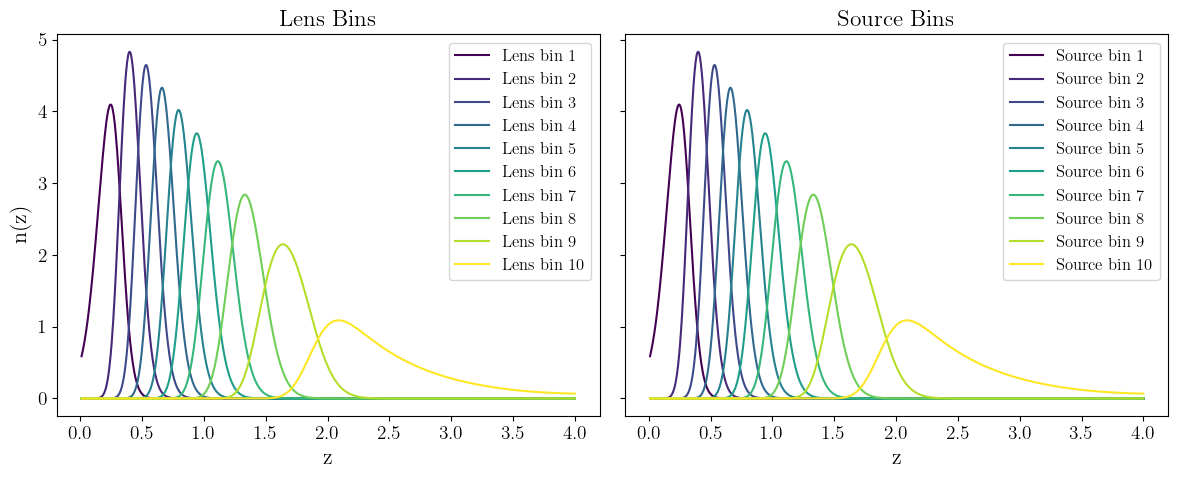

In [328]:
forecast.plot_nz_bins()

# compute power spectra

In [329]:
cl_dict = forecast.compute_cls()

# Example access:
cl_g1g2 = cl_dict["gg"][0, 1]  # Cl for lens bins 1 and 2
cl_g1k3 = cl_dict["gk"][0, 2]  # Cl for galaxy-galaxy lensing (g1 x κ3)
cl_k2k2 = cl_dict["kk"][1, 1]  # Cl for shear-shear (κ2 x κ2)

# Just extract the gk vector

g1k2


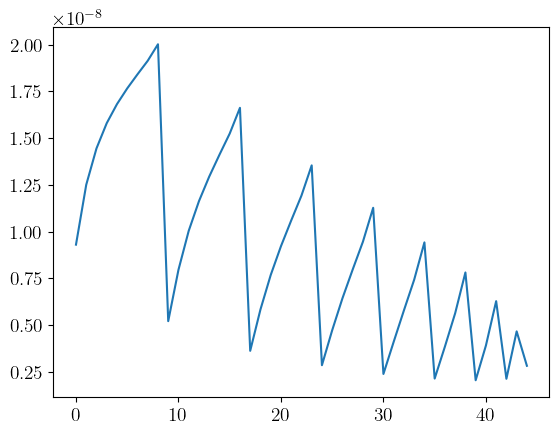

In [330]:
cl_dict = forecast.compute_cls()
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)

# Inspect one element
print(gk_labels[0])       # e.g., "g1k2"
plt.plot(gk_vector)

# covariance of the gk vector

In [331]:
cl_dict = forecast.compute_cls()
ell_eff = ell_eff_uniform_weighting(100, 2000)
cov_gk, gk_labels = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=1900)

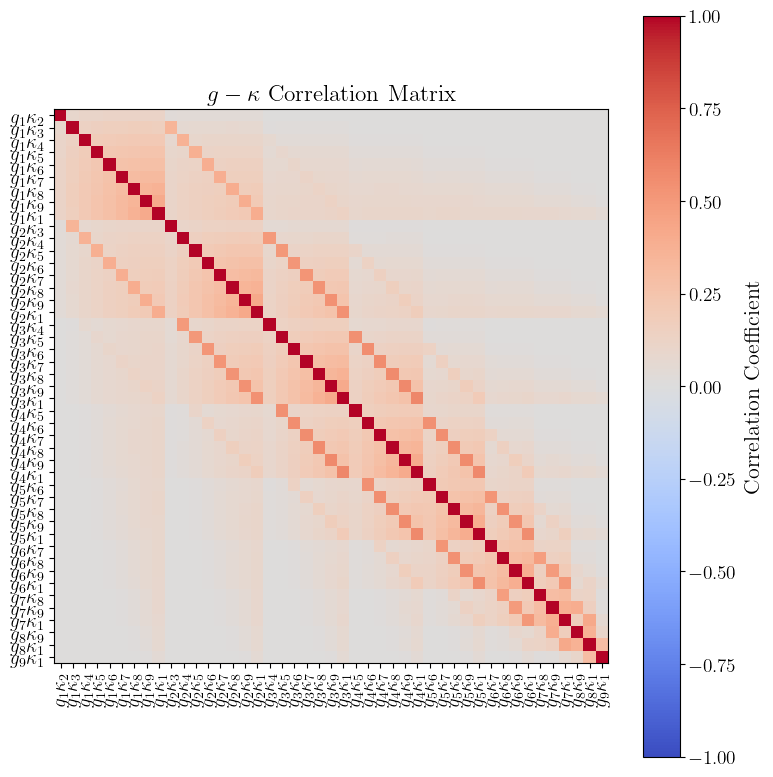

In [332]:
def plot_gk_correlation_matrix(cov_gk, gk_labels):
    import matplotlib.pyplot as plt
    import numpy as np

    corr = cov_gk / np.sqrt(np.outer(np.diag(cov_gk), np.diag(cov_gk)))

    plt.figure(figsize=(8, 8))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, label="Correlation Coefficient")

    # Fix label formatting with LaTeX-safe syntax
    latex_labels = [fr"$g_{{{lbl[1]}}}\kappa_{{{lbl[3]}}}$" for lbl in gk_labels]

    plt.xticks(np.arange(len(gk_labels)), latex_labels, rotation=90)
    plt.yticks(np.arange(len(gk_labels)), latex_labels)
    plt.title(r"$g-\kappa$ Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_gk_correlation_matrix(cov_gk, gk_labels)

Text(0.5, 0, 'monte carlo gk')

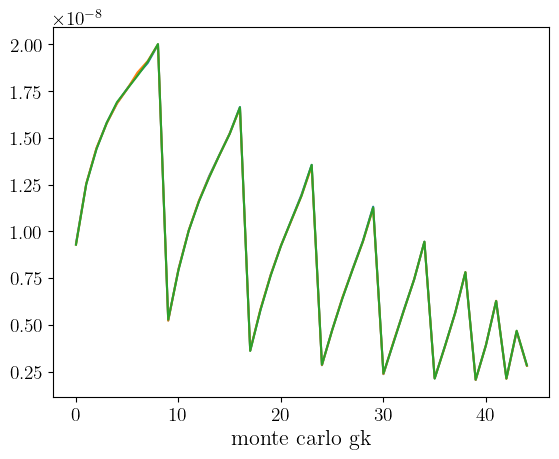

In [333]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=1900)
samples = forecast.sample_gk_vector(gk_vector, gk_cov, nsamples=20000, seed=42)
plt.plot(samples[0])
plt.plot(samples[1])
plt.plot(samples[2])
plt.xlabel('monte carlo gk')

# Shear-Ratio Data vector

In [334]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
R, shear_ratio_labels = forecast.compute_shear_ratios(gk_vector, gk_labels)

Text(0.5, 0, 'shear-ratio DV')

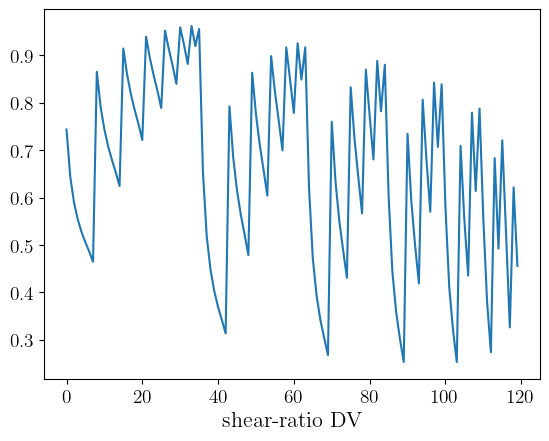

In [335]:
plt.plot(R)
plt.xlabel('shear-ratio DV')

# Shear-ratio covariance

In [336]:
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=1900)
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)

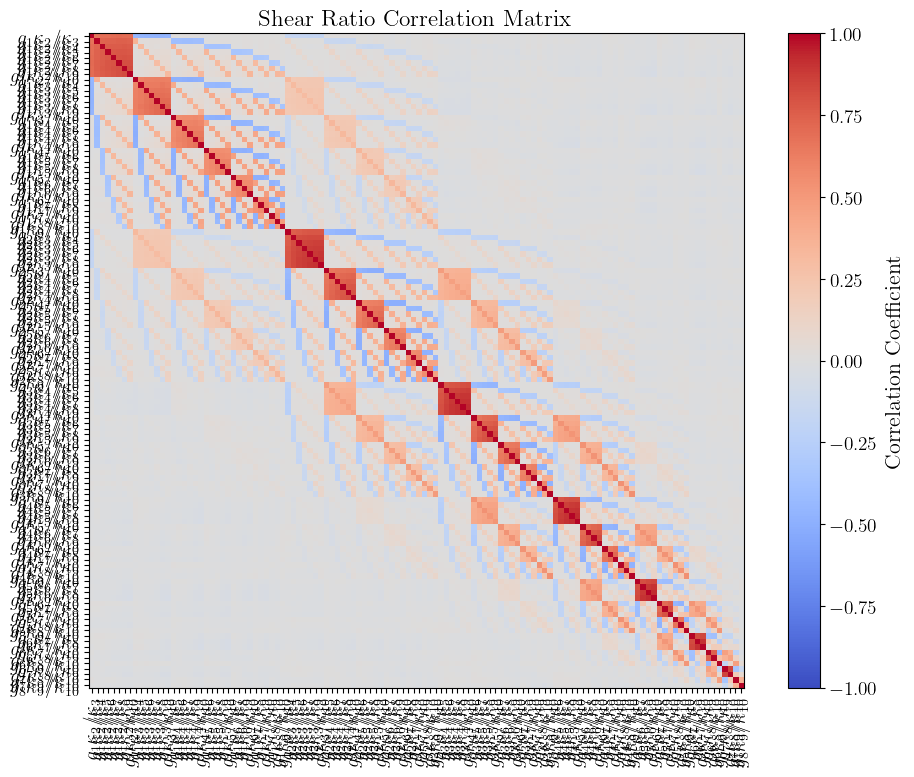

In [337]:
def plot_shear_ratio_correlation_matrix(R_cov, ratio_labels):
    import matplotlib.pyplot as plt
    import numpy as np

    corr = R_cov / np.sqrt(np.outer(np.diag(R_cov), np.diag(R_cov)))

    labels = [fr"$g_{{{i}}}\kappa_{{{j}}}/\kappa_{{{k}}}$" for (i, j, k) in ratio_labels]

    plt.figure(figsize=(10, 8))
    im = plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(im, label="Correlation Coefficient")
    plt.xticks(np.arange(len(labels)), labels, rotation=90)
    plt.yticks(np.arange(len(labels)), labels)
    plt.title("Shear Ratio Correlation Matrix")
    plt.tight_layout()
    plt.show()

plot_shear_ratio_correlation_matrix(R_cov, ratio_labels)

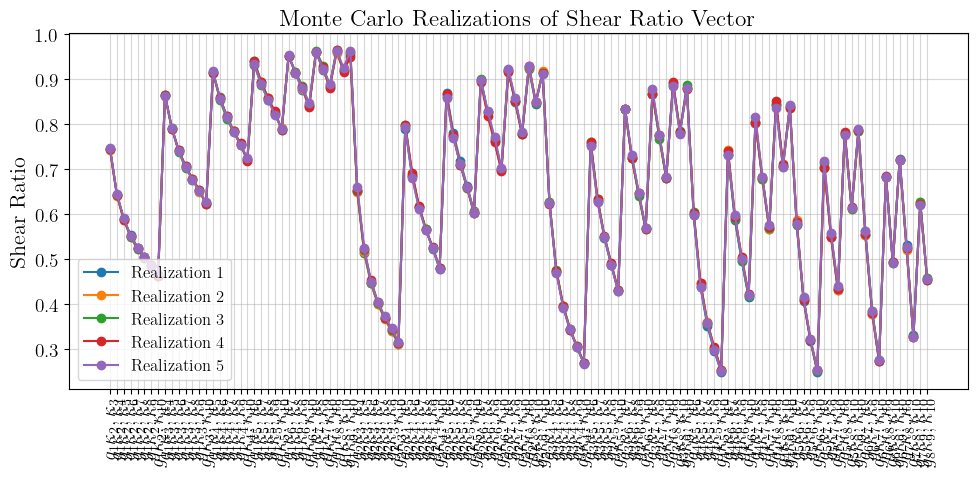

In [338]:
def plot_shear_ratio_mc_realizations(gk_vector, gk_cov, gk_labels, compute_shear_ratios_func, n_draws=5, seed=None):
    """
    Draw and plot a few MC realizations of the shear ratio data vector.

    Parameters
    ----------
    gk_vector : np.ndarray
        Mean gk vector, shape (n_valid, n_ell).
    gk_cov : np.ndarray
        Covariance matrix of gk vector, shape (n_valid, n_valid).
    gk_labels : list of str
        Labels for the gk vector elements.
    compute_shear_ratios_func : callable
        Function to compute shear ratios: (gk_vector, gk_labels) -> (R, labels)
    n_draws : int
        Number of realizations to draw.
    seed : int or None
        Random seed.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    rng = np.random.default_rng(seed)
    n, n_ell = gk_vector.shape
    mean = gk_vector[:, 0]
    samples = rng.multivariate_normal(mean, gk_cov, size=n_draws)
    samples = samples[..., np.newaxis] * np.ones((1, 1, n_ell))  # expand

    all_R = []
    for i in range(n_draws):
        R, labels = compute_shear_ratios_func(samples[i], gk_labels)
        all_R.append(R[:, 0])  # assuming single ell

    all_R = np.array(all_R)
    x = np.arange(all_R.shape[1])

    plt.figure(figsize=(10, 5))
    for i in range(n_draws):
        plt.plot(x, all_R[i], label=f"Realization {i+1}", marker='o')

    xlabels = [fr"$g_{{{i}}}\kappa_{{{j}}},\kappa_{{{k}}}$" for (i, j, k) in labels]
    plt.xticks(x, xlabels, rotation=90)
    plt.ylabel("Shear Ratio")
    plt.title("Monte Carlo Realizations of Shear Ratio Vector")
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.legend()
    plt.show()
    
plot_shear_ratio_mc_realizations(
    gk_vector, gk_cov, gk_labels,
    compute_shear_ratios_func=forecast.compute_shear_ratios,
    n_draws=5, seed=1
)

# Now let's look at the Fisher

In [339]:
# Compute Cls
cl_dict = forecast.compute_cls()

# Extract gk vector and labels
gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)

# Compute gk covariance
ell_eff = ell_eff_uniform_weighting(100, 2000)
gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=1900)

# Compute shear-ratio covariance from Monte Carlo
R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(
    gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42
)

# Derivatives and Fisher matrix
param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}
#param_dict = {k: fid_cosmo[k] for k in ["w0", "wa"]}

derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

# Print parameter errors
errors = np.sqrt(np.diag(np.linalg.inv(Fisher)))
for p, err in zip(param_list, errors):
    print(f"{p:8s} : {err:.4f}")

Omega_m  : 0.1079
h        : 0.2722
w0       : 0.2511
wa       : 1.0696


In [340]:
#forecast.plot_fisher_ellipses(Fisher, param_list, truths={p: fid_cosmo[p] for p in fid_cosmo})

Removed no burn in


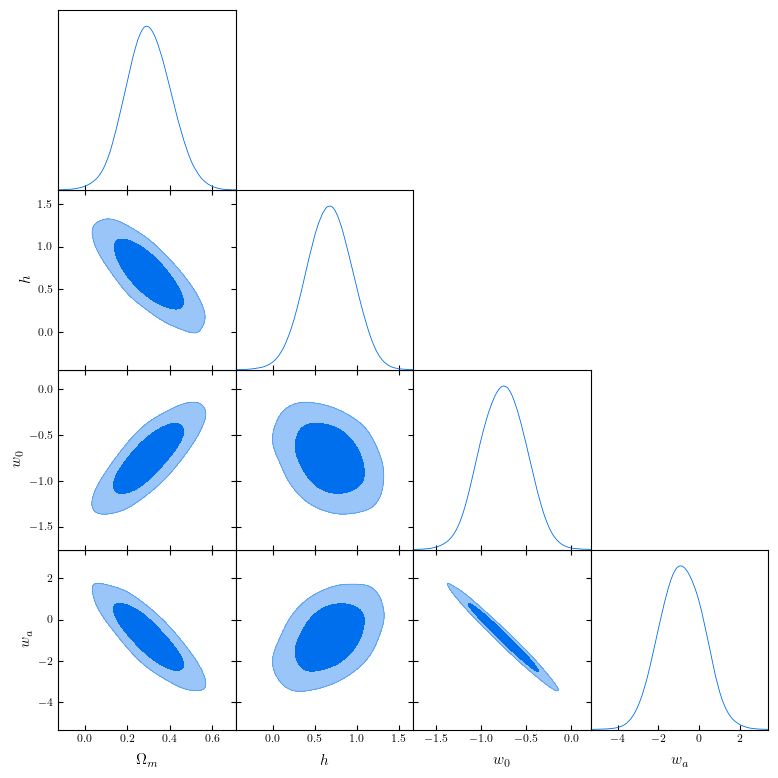

In [341]:
samples, param_list_full = forecast.draw_fisher_samples(Fisher, param_list, truths=fid_cosmo, n_samples=5000)
forecast.plot_fisher_samples_with_getdist(samples, param_list_full, truths=fid_cosmo)

# Combine with the DESI results

Removed no burn in


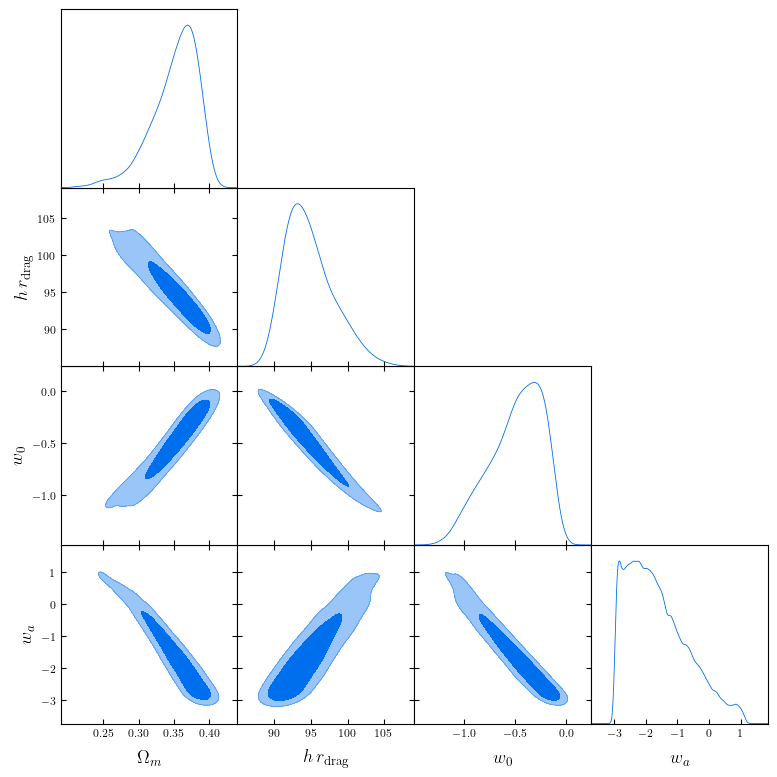

In [357]:
def plot_cobaya_chain_desi_hrdrag(path):
    """
    Load Cobaya DESI-BAO chains, keep hrdrag, plot with GetDist,
    and return the samples as a NumPy array.

    Returns
    -------
    desi_samples : ndarray, shape (N, 4)
        [Omega_m, hrdrag, w0, wa]
    """
    import numpy as np, glob, matplotlib.pyplot as plt
    from getdist import MCSamples
    import getdist.plots as gdplt

    # ---------- locate columns ----------
    with open(f"{path}/chain.1.txt", "r") as f:
        names = f.readline().lstrip("# ").split()

    i_omm, i_hr, i_w0, i_wa = map(names.index, ["omm", "hrdrag", "w", "wa"])

    # ---------- load chains -------------
    raw  = np.vstack([np.loadtxt(f) for f in sorted(glob.glob(f"{path}/chain.*.txt"))])
    pars = raw[:, 2:]                     # drop weight & −logpost
    desi_samples = pars[:, [i_omm-2, i_hr-2, i_w0-2, i_wa-2]]

    # ---------- GetDist -----------------
    names_gd  = ["Omega_m", "hrdrag", "w0", "wa"]
    labels_gd = [r"\Omega_m", r"h\,r_{\mathrm{drag}}", r"w_0", r"w_a"]
    gdsamp    = MCSamples(samples=desi_samples, names=names_gd, labels=labels_gd)

    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "axes.labelsize": 16,
        "font.size": 14,
        "legend.fontsize": 12,
    })

    g = gdplt.get_subplot_plotter()
    g.settings.lab_fontsize    = 16
    g.settings.legend_fontsize = 12
    g.triangle_plot(gdsamp, filled=True)

    globals()["desi_samples"] = desi_samples
    return desi_samples

# call it
desi_samples = plot_cobaya_chain_desi_hrdrag("data/desi-bao-all")

In [358]:
def replace_h_with_hrdrag(samples, param_names, hrdrag_min=70.0, hrdrag_max=110.0, seed=42):
    """
    Replace the h column in the shear-ratio samples with hrdrag samples drawn from a flat prior.

    Parameters
    ----------
    samples : np.ndarray
        Original shear-ratio samples (n_samples, 4).
    param_names : list
        List of parameter names (assumed ['Omega_m', 'h', 'w0', 'wa']).
    hrdrag_min : float
        Minimum value for uniform hrdrag prior.
    hrdrag_max : float
        Maximum value for uniform hrdrag prior.
    seed : int
        Random seed for reproducibility.

    Returns
    -------
    samples_new : np.ndarray
        Modified samples with hrdrag instead of h.
    param_names_new : list
        New parameter names list ['Omega_m', 'hrdrag', 'w0', 'wa'].
    """
    import numpy as np

    rng = np.random.default_rng(seed)

    if param_names != ['Omega_m', 'h', 'w0', 'wa']:
        raise ValueError(f"Expected ['Omega_m', 'h', 'w0', 'wa'], got {param_names}")

    n_samples = samples.shape[0]

    # Draw hrdrag samples
    hrdrag_samples = rng.uniform(hrdrag_min, hrdrag_max, size=n_samples)

    # Replace h column (index 1) with hrdrag
    samples_new = samples.copy()
    samples_new[:, 1] = hrdrag_samples

    param_names_new = ['Omega_m', 'hrdrag', 'w0', 'wa']

    return samples_new, param_names_new
# Assume you already have
# samples, param_list_full = forecast.draw_fisher_samples(...)

samples_hrdrag, param_names_hrdrag = replace_h_with_hrdrag(
    samples,
    param_list_full
)

In [371]:
from CombineHarvesterFlow import Harvest
from CombineHarvesterFlow import Combine

In [372]:
desi_samples_low = desi_samples[50000::10,:]
desi = Harvest('output/desi', chain = desi_samples_low, n_flows = 3)
lens = Harvest('output/lens', chain = samples_hrdrag, n_flows = 3)


In [374]:
desi.harvest()
lens.harvest()

Training the flows


 21%|████████▍                               | 21/100 [00:10<00:38,  2.06it/s, train=0.47830695, val=0.49708346 (Max patience reached)]


Training the flows


 16%|██████▋                                   | 16/100 [00:06<00:36,  2.32it/s, train=3.0931787, val=3.2529907 (Max patience reached)]


In [375]:
combined = Combine(desi, lens)

In [377]:
desi_weights, lens_weights = combined.combine()

Removed no burn in


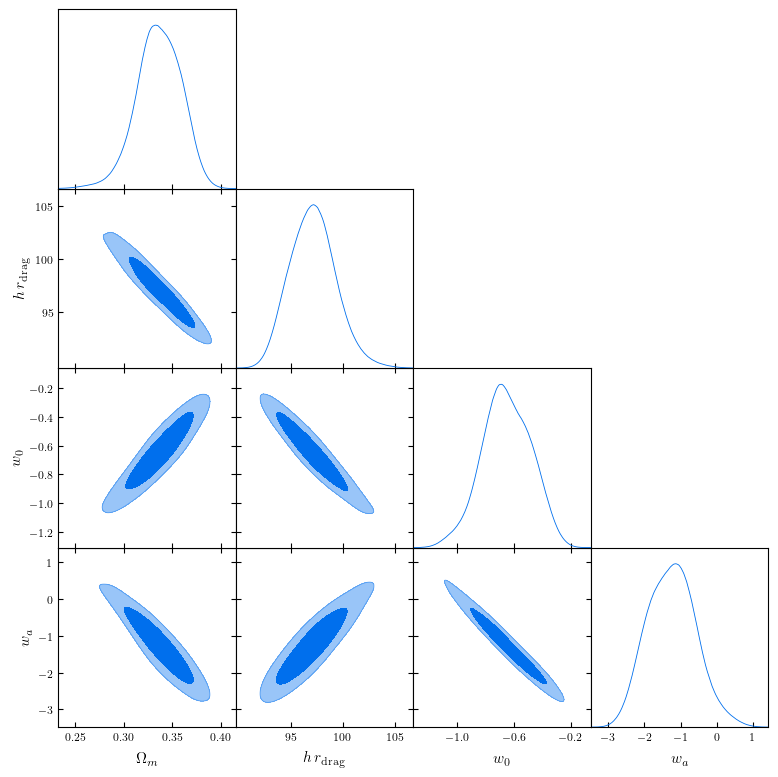

In [379]:
from getdist import MCSamples
import getdist.plots as gdplt
import matplotlib.pyplot as plt

# Parameter setup
param_names = ["Omega_m", "hrdrag", "w0", "wa"]
latex_labels = [r"\Omega_m", r"h\,r_{\mathrm{drag}}", r"w_0", r"w_a"]

# Create MCSamples instance
samples = MCSamples(samples=desi_samples_low, weights=desi_weights,
                    names=param_names, labels=latex_labels)

# Plot with GetDist
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 14,
    "legend.fontsize": 12,
})

g = gdplt.get_subplot_plotter()
g.triangle_plot(samples, filled=True)

Removed no burn in
Removed no burn in
Removed no burn in


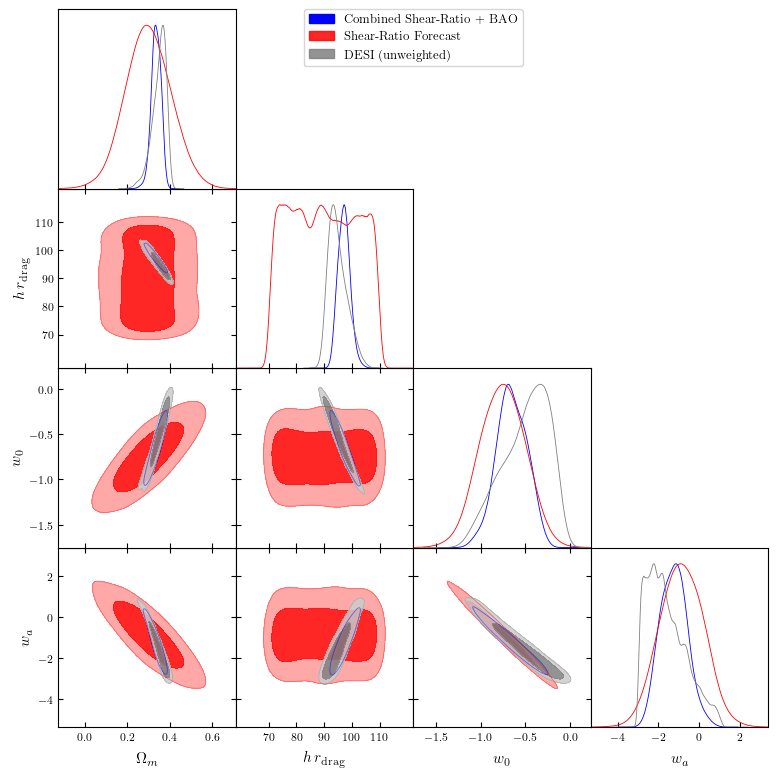

In [382]:
from getdist import MCSamples
import getdist.plots as gdplt
import matplotlib.pyplot as plt

# --- Set up the parameter names and LaTeX labels ---
param_names = ["Omega_m", "hrdrag", "w0", "wa"]
latex_labels = [r"\Omega_m", r"h\,r_{\mathrm{drag}}", r"w_0", r"w_a"]

# --- Create MCSamples objects ---
desi_weighted = MCSamples(samples=desi_samples_low, weights=desi_weights,
                          names=param_names, labels=latex_labels)

desi_unweighted = MCSamples(samples=desi_samples_low,
                            names=param_names, labels=latex_labels)

samples_hrdrag_obj = MCSamples(samples=samples_hrdrag,
                               names=param_names, labels=latex_labels)

# --- Matplotlib style ---
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "axes.labelsize": 16,
    "font.size": 14,
    "legend.fontsize": 12,
})

# --- Plot ---
g = gdplt.get_subplot_plotter()
g.triangle_plot(
    [desi_weighted, samples_hrdrag_obj, desi_unweighted],
    filled=True,
    legend_labels=["Combined Shear-Ratio + BAO", "Shear-Ratio Forecast", "DESI (unweighted)"],
    contour_colors=["blue", "red", "gray"]
)

# plot the difference

In [218]:
def plot_shear_ratio_differences(forecast, cl_dict, gk_labels, R_cov, w0_vals=[-1.0, -0.5], color_cycle=None):
    """
    Plot the difference between the shear ratio data vector and the fiducial model.

    Parameters
    ----------
    forecast : Forecast3x2pt
        Initialized forecast object.
    cl_dict : dict
        Fiducial Cl dictionary.
    gk_labels : list
        Labels from extract_gk_vector().
    R_cov : np.ndarray
        Shear ratio covariance matrix.
    w0_vals : list
        Values of w0 to compare (excluding fiducial).
    color_cycle : list or None
        Optional list of matplotlib colors.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    R_err = np.sqrt(np.diag(R_cov))
    fid_backup = forecast.fid_cosmo.copy()
    w0_fid = fid_backup["w0"]

    if color_cycle is None:
        color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    plt.figure(figsize=(12, 6))

    # Compute fiducial model
    forecast.fid_cosmo = fid_backup.copy()
    forecast._init_cosmology()
    gk_vec_fid, _ = forecast.extract_gk_vector(cl_dict)
    R_fid, ratio_labels = forecast.compute_shear_ratios(gk_vec_fid, gk_labels)

    x = np.arange(len(R_fid))

    # Plot zero line
    plt.axhline(0, color='black')

    # Error bars centered at 0
    plt.errorbar(x, np.zeros_like(x), yerr=R_err, fmt='o', color='black',
                 label=f"Fiducial (w0 = {w0_fid})", capsize=3)

    # Differences
    for idx, w0 in enumerate(w0_vals):
        forecast.fid_cosmo = fid_backup.copy()
        forecast.fid_cosmo["w0"] = w0
        forecast._init_cosmology()
        cl_new = forecast.compute_cls()
        gk_vec_new, _ = forecast.extract_gk_vector(cl_new)
        R_new, _ = forecast.compute_shear_ratios(gk_vec_new, gk_labels)
        diff = R_new[:, 0] - R_fid[:, 0]
        plt.scatter(x, diff, label=f"w0 = {w0}", color=color_cycle[idx % len(color_cycle)])

    # Restore
    forecast.fid_cosmo = fid_backup.copy()
    forecast._init_cosmology()

    xlabels = [f"g{i}/k{j},{k}" for (i, j, k) in ratio_labels]
    plt.xticks(x, xlabels, rotation=90, fontsize=5)
    plt.ylabel("Shear Ratio Difference")
    plt.title("Difference from Fiducial Shear Ratio")
    plt.legend()
    plt.tight_layout()
    plt.show()


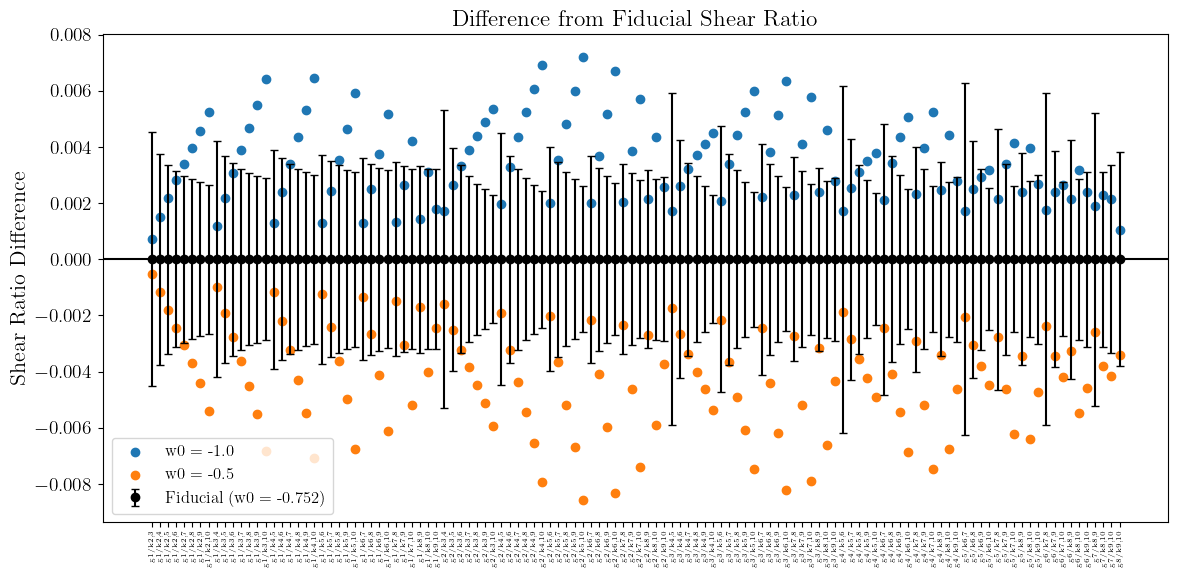

In [219]:
plot_shear_ratio_differences(forecast, cl_dict, gk_labels, R_cov, w0_vals=[-1.0, -0.5])

# Let's see what happens as a function of ell. Conclusion set a global l_max of 2000.

In [145]:
'''
import numpy as np
import matplotlib.pyplot as plt

# --- Setup ---
ell_min = 100
ell_max_list = [1000, 2000, 3000, 4000]

area_deg2 = 14300
n_eff = 27.1
sigma_eps = 0.26
bias_lens = [1.4] * 10

fid_cosmo = {
    "Omega_m": 0.3,
    "Omega_b": 0.05,
    "h": 0.67,
    "sigma_8": 0.8,
    "n_s": 0.96,
    "w0": -0.752,
    "wa": -0.86
}

param_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}

# --- Storage ---
ell_max_vals = []
w0_errors_ssc_on = []
w0_errors_ssc_off = []

forecast = Forecast3x2pt(nz_lens=nz_lens,
    nz_src=nz_src,
    ell=np.array([ell_eff]),
    area_deg2=area_deg2,
    n_eff=n_eff,
    sigma_eps=sigma_eps,
    bias_lens=bias_lens,
    fid_cosmo=fid_cosmo
)


# --- Loop ---
for ell_max in ell_max_list:
    ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)
    delta_ell = ell_max - ell_min
    forecast.ell = np.array([ell_eff])

    # Compute Cls
    cl_dict = forecast.compute_cls()

    # Extract gk vector and labels
    gk_vector, gk_labels = forecast.extract_gk_vector(cl_dict)

    # SSC ON
    forecast.use_ssc = True
    print(f"Running shear-ratio Fisher for ell_max = {ell_max} [SSC ON]")
    gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=delta_ell)
    R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)

    derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
    Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

    cov = np.linalg.inv(Fisher)
    idx_w0 = param_list.index("w0")
    w0_error = np.sqrt(cov[idx_w0, idx_w0])
    w0_errors_ssc_on.append(w0_error)
    print(f"   --> w0 error with SSC: {w0_error:.4f}")

    # SSC OFF
    forecast.use_ssc = False
    print(f"Running shear-ratio Fisher for ell_max = {ell_max} [SSC OFF]")
    gk_cov, _ = forecast.compute_gk_covariance_matrix(cl_dict, ell=ell_eff, delta_ell=delta_ell)
    R_cov, R_mean, ratio_labels = forecast.monte_carlo_shear_ratio_cov(gk_vector, gk_cov, gk_labels, nsamples=20000, seed=42)

    derivs, R_fid, _ = forecast.compute_shear_ratio_derivatives(cl_dict, gk_labels, param_dict)
    Fisher, param_list = forecast.compute_shear_ratio_fisher(R_cov, derivs)

    cov = np.linalg.inv(Fisher)
    idx_w0 = param_list.index("w0")
    w0_error = np.sqrt(cov[idx_w0, idx_w0])
    w0_errors_ssc_off.append(w0_error)
    print(f"   --> w0 error without SSC: {w0_error:.4f}")

    ell_max_vals.append(ell_max)

# --- Plot ---
plt.figure(figsize=(8, 6))
plt.plot(ell_max_vals, w0_errors_ssc_on, marker='o', label="With SSC")
plt.plot(ell_max_vals, w0_errors_ssc_off, marker='s', label="Without SSC")
plt.xlabel(r"$\ell_{\rm max}$")
plt.ylabel(r"$\sigma(w_0)$")
plt.title(r"Shear-Ratio Forecast: $\sigma(w_0)$ vs $\ell_{\rm max}$")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
'''

<>:1: SyntaxWarning: invalid escape sequence '\e'
<>:1: SyntaxWarning: invalid escape sequence '\e'
/var/folders/_6/cyl8jkxn751g7gz3gtyl8h240000gq/T/ipykernel_12672/682593543.py:1: SyntaxWarning: invalid escape sequence '\e'
  '''


'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# --- Setup ---\nell_min = 100\nell_max_list = [1000, 2000, 3000, 4000]\n\narea_deg2 = 14300\nn_eff = 27.1\nsigma_eps = 0.26\nbias_lens = [1.4] * 10\n\nfid_cosmo = {\n    "Omega_m": 0.3,\n    "Omega_b": 0.05,\n    "h": 0.67,\n    "sigma_8": 0.8,\n    "n_s": 0.96,\n    "w0": -0.752,\n    "wa": -0.86\n}\n\nparam_dict = {k: fid_cosmo[k] for k in ["Omega_m", "h", "w0", "wa"]}\n\n# --- Storage ---\nell_max_vals = []\nw0_errors_ssc_on = []\nw0_errors_ssc_off = []\n\nforecast = Forecast3x2pt(nz_lens=nz_lens,\n    nz_src=nz_src,\n    ell=np.array([ell_eff]),\n    area_deg2=area_deg2,\n    n_eff=n_eff,\n    sigma_eps=sigma_eps,\n    bias_lens=bias_lens,\n    fid_cosmo=fid_cosmo\n)\n\n\n# --- Loop ---\nfor ell_max in ell_max_list:\n    ell_eff = ell_eff_uniform_weighting(ell_min, ell_max)\n    delta_ell = ell_max - ell_min\n    forecast.ell = np.array([ell_eff])\n\n    # Compute Cls\n    cl_dict = forecast.compute_cls()\n\n    # Extract g

In [146]:
import CombineHarvesterFlow